In [109]:
import os
import pandas as pd

# cr -> Crop Recommendation
cr_file_path = "../Data/Combined_CR.csv"

if not os.path.exists(cr_file_path):
    raise ValueError("Crop recommendation file cannot be found.")

cr_df = pd.read_csv(cr_file_path)
print(f"\"{cr_file_path}\" was loaded.")
print(cr_df.head())

del cr_file_path

"../Data/Combined_CR.csv" was loaded.
    N   P   K  temperature   humidity        ph    rainfall label
0  90  42  43    20.879744  82.002744  6.502985  202.935536  rice
1  85  58  41    21.770462  80.319644  7.038096  226.655537  rice
2  60  55  44    23.004459  82.320763  7.840207  263.964248  rice
3  74  35  40    26.491096  80.158363  6.980401  242.864034  rice
4  78  42  42    20.130175  81.604873  7.628473  262.717340  rice


Columns of Crop Recommendation file: ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 'label']
Information about each column:
	- Name: 'N'
		> Max: 140;
		> Min: 0;
		> Mean: 49.10658016682113;
		> Median: 36.0;
		> Deviation: 36.2505113976222;
		> Has null values: False.


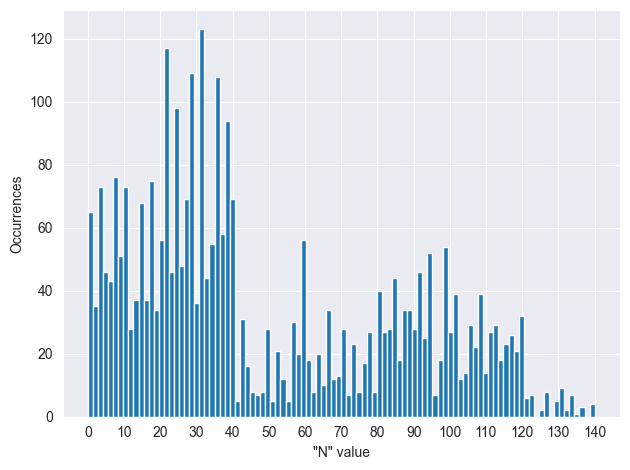

	- Name: 'P'
		> Max: 145;
		> Min: 5;
		> Mean: 54.195860364535065;
		> Median: 53.0;
		> Deviation: 31.34429321420288;
		> Has null values: False.


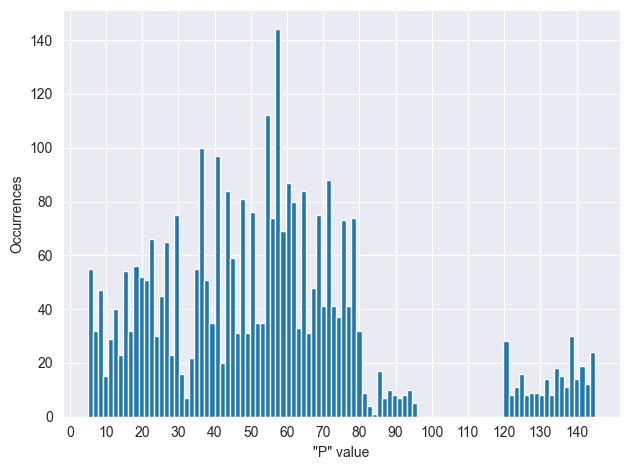

	- Name: 'K'
		> Max: 205;
		> Min: 5;
		> Mean: 47.23941921532283;
		> Median: 31.0;
		> Deviation: 48.6970258281558;
		> Has null values: False.


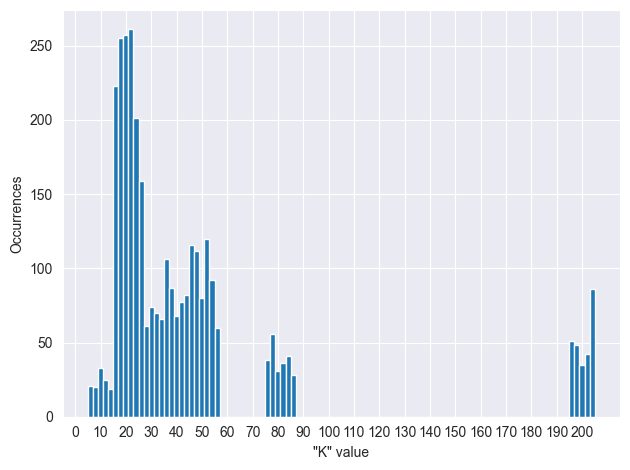

	- Name: 'temperature'
		> Max: 43.67549305;
		> Min: 8.825674745;
		> Mean: 25.382612738353107;
		> Median: 25.4438391;
		> Deviation: 5.107548007302451;
		> Has null values: False.


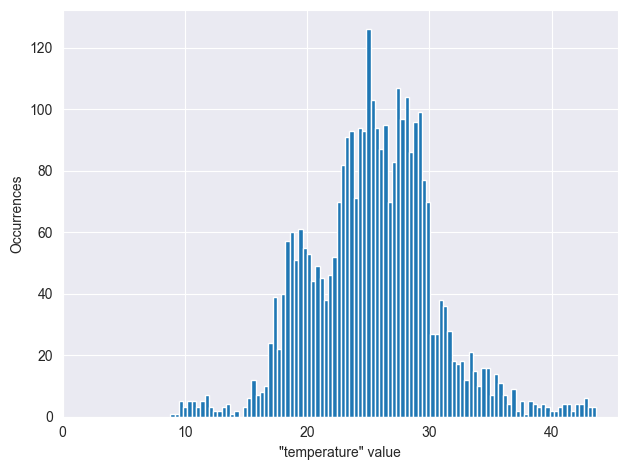

	- Name: 'humidity'
		> Max: 99.98187601;
		> Min: 14.25803981;
		> Mean: 68.20052172735866;
		> Median: 79.28693687;
		> Deviation: 24.48135810881288;
		> Has null values: False.


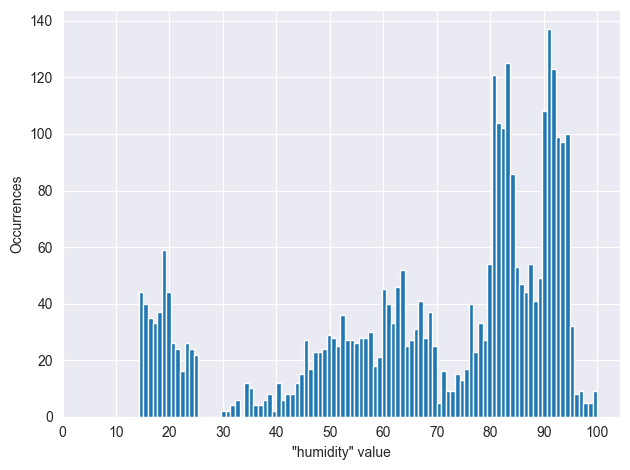

	- Name: 'ph'
		> Max: 9.93509073;
		> Min: 3.504752314;
		> Mean: 6.481701768808156;
		> Median: 6.425419926;
		> Deviation: 0.8382613125972713;
		> Has null values: False.


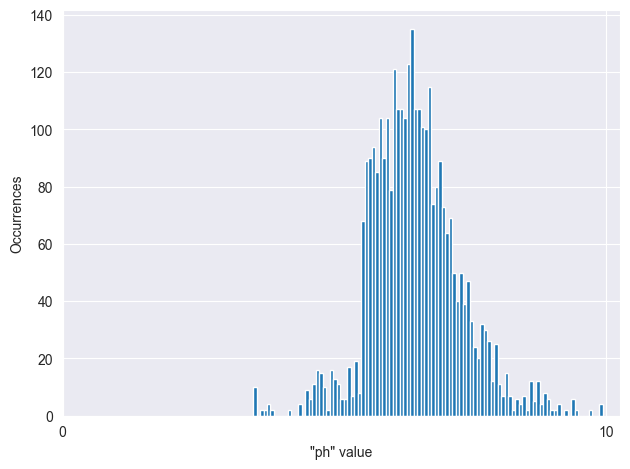

	- Name: 'rainfall'
		> Max: 298.5601175;
		> Min: 5.31450727;
		> Mean: 100.41776197558232;
		> Median: 91.82271568;
		> Deviation: 54.45630861519395;
		> Has null values: False.


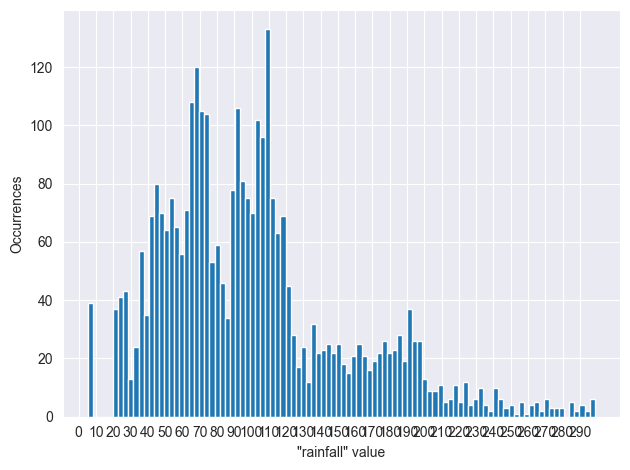

In [110]:
import matplotlib.pyplot as plt
import numpy as np

cols = list(cr_df.columns)
print(f"Columns of Crop Recommendation file: {cols}")

print("Information about each column:")
for c in cols[:-1]:
    # print(f"\t- {c} - Max: {cr_df[c].max()}; Min: {cr_df[c].min()}; Mean: {cr_df[c].mean()}; Median: {cr_df[c].median()}; Deviation: {cr_df[c].std()}" )
    print(f"\t- Name: '{c}'")
    print(f"\t\t> Max: {cr_df[c].max()};")
    print(f"\t\t> Min: {cr_df[c].min()};")
    print(f"\t\t> Mean: {cr_df[c].mean()};")
    print(f"\t\t> Median: {cr_df[c].median()};")
    print(f"\t\t> Deviation: {cr_df[c].std()};")
    print(f"\t\t> Has null values: {cr_df[c].isnull().values.any()}.")
    plt.xlabel(f"\"{c}\" value")
    plt.ylabel("Occurrences")
    plt.hist(cr_df[c].sort_values(), bins=100)
    plt.tight_layout()
    plt.xticks(np.arange(0, cr_df[c].max() + 1, 10))
    plt.show()

label
apple          134
banana         145
beans          100
blackgram      100
chickpea       100
coconut        100
coffee         144
cotton         130
cowpeas        100
grapes         128
groundnuts     100
jute           100
kidneybeans    100
lentil         100
maize          149
mango          130
mothbeans      100
mungbean       100
muskmelon      132
orange         131
papaya         141
peas           100
pigeonpeas     100
pomegranate    133
rice           176
soyabeans      130
watermelon     134
dtype: int64


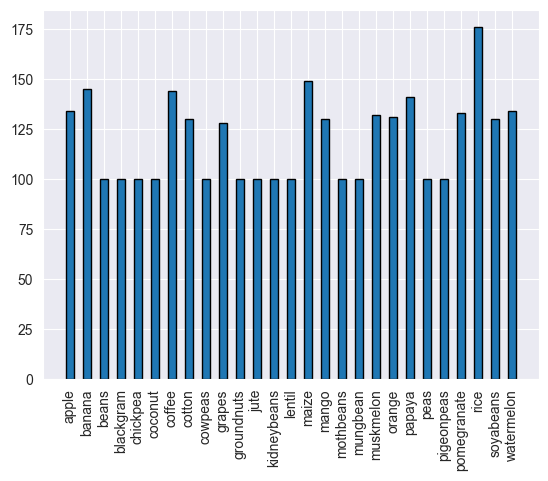

In [111]:
all_labels = cr_df["label"].unique()

print(cr_df.groupby("label").size())

plt.xticks(rotation=90)
plt.hist(cr_df["label"].sort_values(), bins=np.arange(all_labels.size + 1) - 0.5, rwidth=0.5, align="mid", ec="k")
plt.show()

## Data
As you can see the dataset is already cleaned up and balanced

### TODO
- Show correlation matrix (attributes)
- Show histogram of each column for each label as well metrics such, max value, min etc

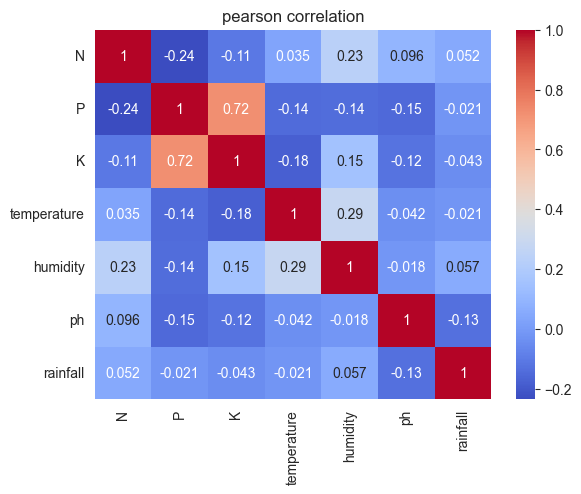

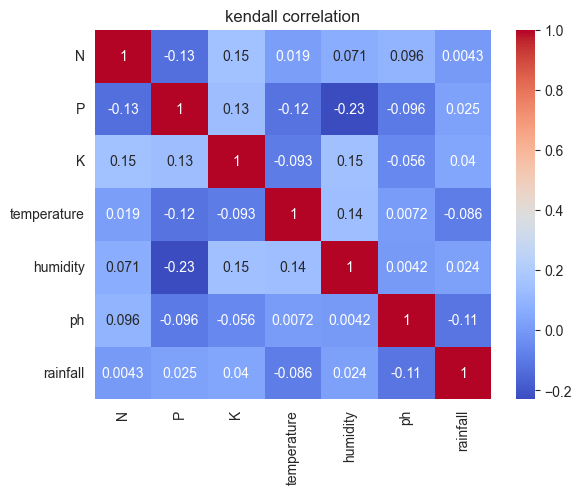

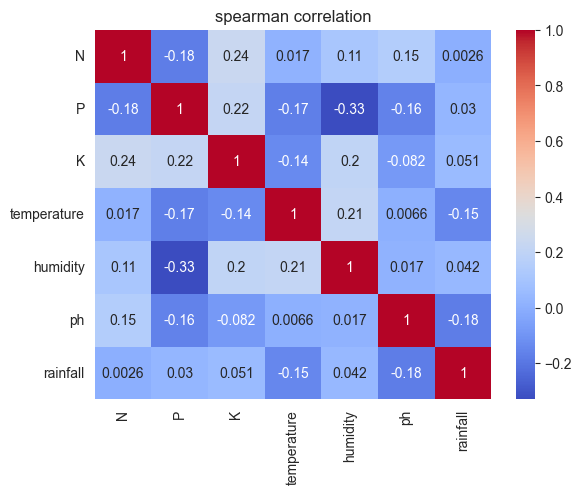

In [112]:
import seaborn as sns

for m in ["pearson", "kendall", "spearman"]:
    attr_corr = cr_df[cols[:-1]].corr(method=m)
    plt.figure()
    plt.title(f"{m} correlation")
    sns.heatmap(attr_corr, annot=True, cmap="coolwarm", xticklabels=attr_corr.columns.values, yticklabels=attr_corr.columns.values);

In [113]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(cr_df[cols[:-1]], cr_df[cols[-1]], test_size=0.25)

In [114]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def get_stats_of(model_name: str, y_test: any, y_pred: any) -> str:
    return f"{model_name} - Accuracy: {accuracy_score(y_test, y_pred) * 100} - Precision: {precision_score(y_test, y_pred, average='weighted') * 100} - Recall: {recall_score(y_test, y_pred, average='weighted') * 100} - F1-Score: {f1_score(y_test, y_pred, average='weighted') * 100}"

In [121]:
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(x_train)

lor_model = LogisticRegression()
lor_model.fit(x_train, y_train)

print(get_stats_of("LoR", y_test, lor_model.predict(x_test)))

LoR - Accuracy: 75.67901234567901 - Precision: 75.70628525859793 - Recall: 75.67901234567901 - F1-Score: 74.61762186058934


/Users/mmagueijo/Documents/Code/CropRecommendation/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LoR - Accuracy: 72.22222222222221 - Precision: 72.15779646637135 - Recall: 72.22222222222221 - F1-Score: 72.11213062553647


<Axes: >

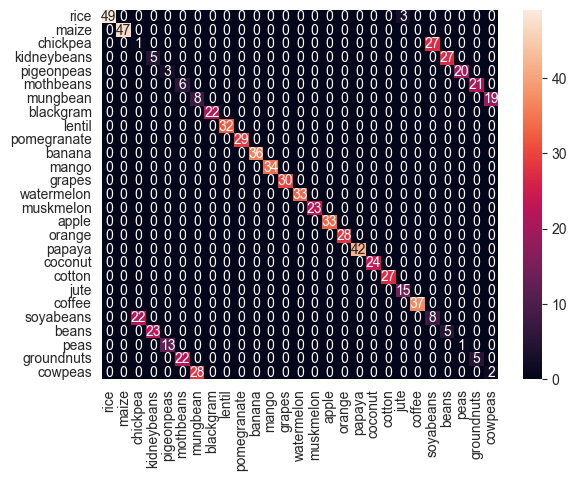

In [123]:
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns

rf_model = RandomForestClassifier()
rf_model.fit(x_train, y_train)
rf_pred = rf_model.predict(x_test)

print(get_stats_of("LoR", y_test, rf_pred))


sns.heatmap(confusion_matrix(y_test, rf_pred, labels=all_labels), annot=True, yticklabels=all_labels, xticklabels=all_labels)